<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/bayes/bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Statistics (Unfinished)


In [2]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# We borrow material from "Bayesian Analysis with Python (2nd end)" by Osvaldo Martin
#https://github.com/aloctavodia/BAP

# To avoid installing from the internet every time you open a colab,
# you can use this 
# https://stackoverflow.com/questions/55253498/how-do-i-install-a-library-permanently-in-colab

!pip install pymc3>=3.8

import pymc3 as pm
pm.__version__

     |████████████████████████████████| 911kB 8.0MB/s 
     |████████████████████████████████| 1.5MB 30.4MB/s 
     |████████████████████████████████| 4.1MB 35.9MB/s 
     |████████████████████████████████| 327kB 42.1MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


'3.8'

In [4]:
!pip install arviz
import arviz as az

# Beta-Binomial model



## Exact inference

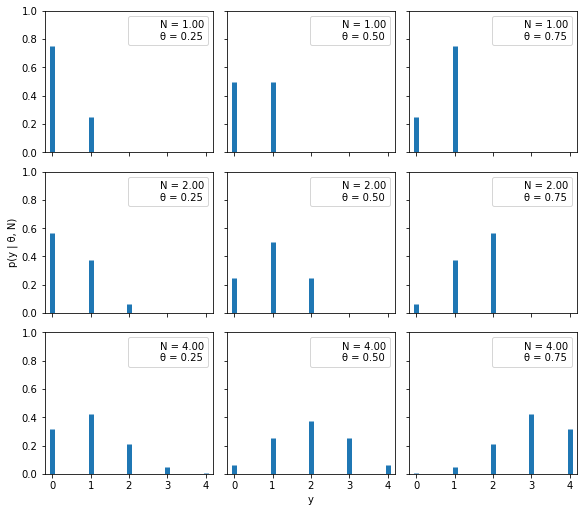

In [0]:
# Plot the Binomial likelihood

n_params = [1, 2, 4]  # Number of trials
p_params = [0.25, 0.5, 0.75]  # Probability of success

x = np.arange(0, max(n_params)+1)
f,ax = plt.subplots(len(n_params), len(p_params), sharex=True, sharey=True,
                    figsize=(8, 7), constrained_layout=True)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]

        y = stats.binom(n=n, p=p).pmf(x)

        ax[i,j].vlines(x, 0, y, colors='C0', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="N = {:3.2f}\nθ = {:3.2f}".format(n,p), alpha=0)
        ax[i,j].legend()

        ax[2,1].set_xlabel('y')
        ax[1,0].set_ylabel('p(y | θ, N)')
        ax[0,0].set_xticks(x)


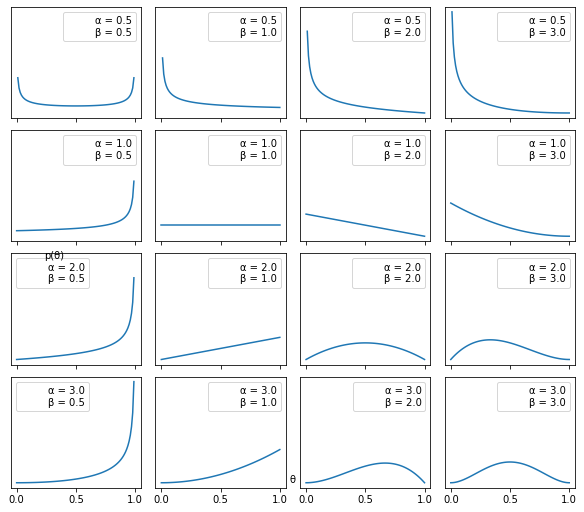

In [0]:
# Plot the beta prior

params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True,
                     figsize=(8, 7), constrained_layout=True)
for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a, b), alpha=0)
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, 'θ', ha='center')
f.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)


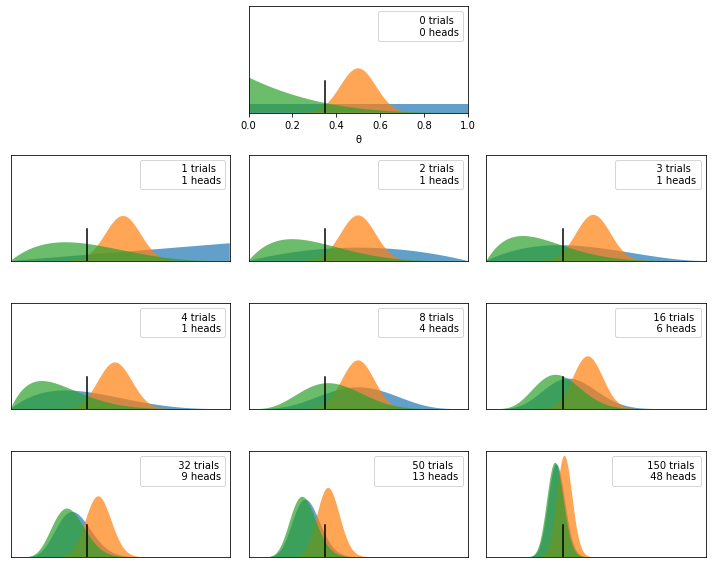

In [0]:
# Compute and plot posterior (black vertical line = true parameter value)

plt.figure(figsize=(10, 8))

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35

beta_params = [(1, 1), (20, 20), (1, 4)]
dist = stats.beta
x = np.linspace(0, 1, 200)

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
        plt.xlabel('θ')
    else:
        plt.subplot(4, 3, idx+3)
        plt.xticks([])
    y = data[idx]
    for (a_prior, b_prior) in beta_params:
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.fill_between(x, 0, p_theta_given_y, alpha=0.7)

    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label=f'{N:4d} trials\n{y:4d} heads', alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend()
    plt.yticks([])
plt.tight_layout()


## Credible intervals <a class="anchor" id="credible"></a>




In [0]:
# We illustrate how to compute a 95% posterior credible interval for a random variable
# with a beta distribution.

from scipy.stats import beta

np.random.seed(42)
theta_real = 0.35
ntrials = 100
data = stats.bernoulli.rvs(p=theta_real, size=ntrials)

N = ntrials; N1 = sum(data); N0 = N-N1; # Sufficient statistics
aprior = 1; bprior = 1; # prior
apost = aprior + N1; bpost = bprior + N0 # posterior

# Interval function
alpha = 0.05
CI1 = beta.interval(1-alpha, apost, bpost)
print('{:0.2f}--{:0.2f}'.format(CI1[0], CI1[1])) # (0.06:0.52) 

# Use the inverse CDF (percent point function)
l  = beta.ppf(alpha/2, apost, bpost)
u  = beta.ppf(1-alpha/2, apost, bpost)
CI2 = (l,u)
print('{:0.2f}--{:0.2f}'.format(CI2[0], CI2[1])) # (0.06:0.52) 

# Use Monte Carlo sampling
samples = beta.rvs(apost, bpost, size=10000)
samples = np.sort(samples)
CI3 = np.percentile(samples, 100*np.array([alpha/2, 1-alpha/2])) 
print('{:0.2f}--{:0.2f}'.format(CI3[0], CI3[1])) # (0.06:0.51) 
print(np.mean(samples))


0.24--0.42
0.24--0.42
0.24--0.42
0.3230834644012448


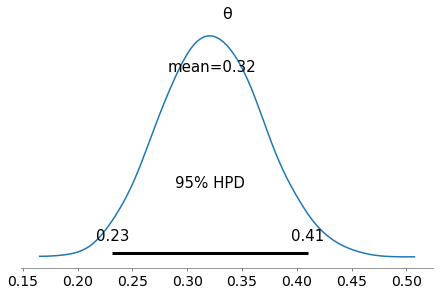

In [0]:
# The arviz package (https://github.com/arviz-devs/arviz) can be used to make plots
# of high posterior density intervals, as shown below.
# By default, it shows the 94\% interval, but we change it to 95%.

az.plot_posterior({'θ':samples}, credible_interval=0.95);



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f886bd68a20>],
      dtype=object)

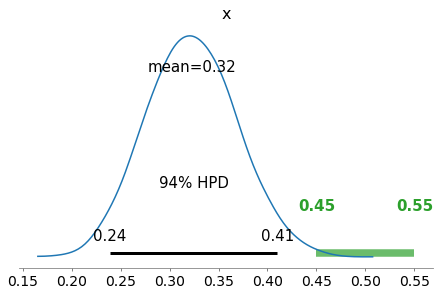

In [0]:
# See if the parameter is inside the region of practical equivalence centered at 0.5
az.plot_posterior(samples, rope=[0.45, .55])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f886ce412b0>],
      dtype=object)

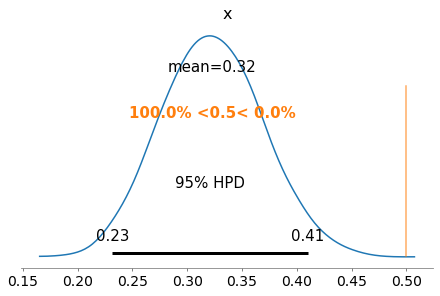

In [0]:
# From the above plot, we see that the HPD does not overlap the ROPE,
#so we can confidently say the parameter is "significiantly different" from 0.5

# We can also verify this by checking if 0.5 is in the HPD
az.plot_posterior(samples,  credible_interval=0.95, ref_val=0.5)

## Point estimates

We minimize the posterior expected loss, using L2 loss (estimator is posterior mean) or L1 loss (estimator is posterior median).

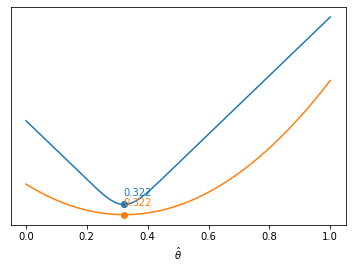

In [0]:
grid = np.linspace(0, 1, 200)
θ_pos = samples #trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.3f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

## MCMC inference 

We will use pymc3 to approximate the posterior of this simple model.
Code is based on [this notebook](https://github.com/aloctavodia/BAP/blob/master/code/Chp202%20Programming%20probabilistically.ipynb).



In [0]:
data # same as above

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0])

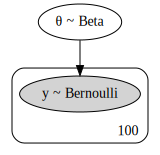

In [0]:
with pm.Model() as model:
    # a priori
    θ = pm.Beta('θ', alpha=aprior, beta=bprior)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)

pm.model_to_graphviz(model) # show the DAG

In [0]:
# run MCMC (defaults to 2 chains)
with model:
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 1948.20it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88652de898>,
      dtype=object)

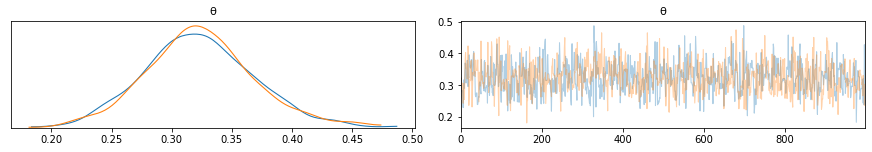

In [0]:
# Show trace plot to assess convergence
az.plot_trace(trace)


In [0]:
# Summarize  posterior samples
az.summary(trace)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.324,0.045,0.237,0.407,0.002,0.001,867.0,867.0,851.0,1292.0,1.01


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8862c3a470>],
      dtype=object)

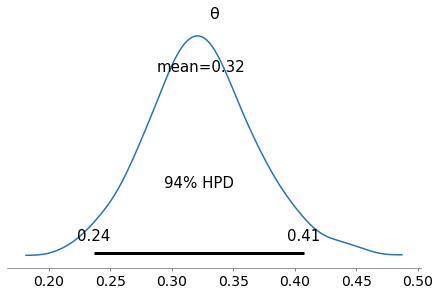

In [0]:
# The samples from MCMC (called "trace") should be similar to the exact
# iid samples from the posterior, plotted above
az.plot_posterior(trace)


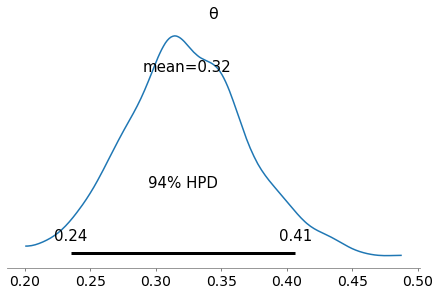

In [0]:
# Convert posterior samples into a parametric distribution
trace_approx = pm.Empirical(trace, model=model)
# Now plot samples from this distribution
pm.plot_posterior(trace_approx.sample(1000));

## Variational inference 

We use automatic differentiation VI.
Details can be found at https://docs.pymc.io/notebooks/variational_api_quickstart.html

In [5]:
from pymc3.variational.callbacks import CheckParametersConvergence
with model:
    post = pm.fit(method='advi', callbacks=[CheckParametersConvergence()]); # mean field approximation


NameError: ignored

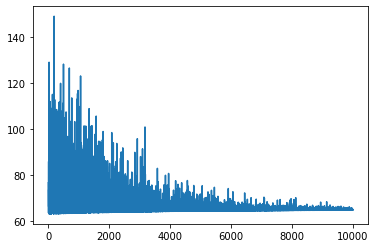

In [0]:
# Plot negative ELBO vs iteration to assess convergence
plt.plot(post.hist);

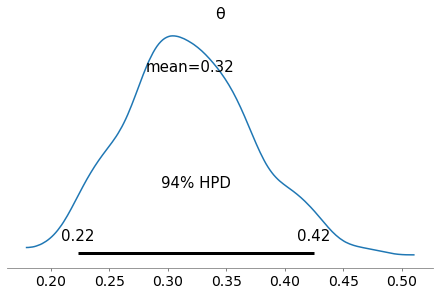

In [0]:
pm.plot_posterior(post.sample(1000));

# 1d Gaussian 

## Exact inference

To be completed

## MCMC inference

In [12]:
# We use a dataset of "chemical shifts", that has a couple of "outliers"
url = 'https://github.com/aloctavodia/BAP/blob/master/code/data/chemical_shifts.csv'
url = 'https://raw.githubusercontent.com/aloctavodia/BAP/master/code/data/chemical_shifts.csv'

df = pd.read_csv(url)
# b=df.iloc[:,1:].values
#data = df.to_numpy() 
data = df.iloc[:,0].values
print(data.shape)
print(data)

(47,)
[55.12 53.73 50.24 52.05 56.4  48.45 52.34 55.65 51.49 51.86 63.43 53.
 56.09 51.93 52.31 52.33 57.48 57.44 55.14 53.93 54.62 56.09 68.58 51.36
 55.47 50.73 51.94 54.95 50.39 52.91 51.5  52.68 47.72 49.73 51.82 54.99
 52.84 53.19 54.52 51.46 53.73 51.61 49.81 52.42 54.3  53.84 53.16]


([<matplotlib.axis.YTick at 0x7f1ac77379e8>],
 <a list of 1 Text major ticklabel objects>)

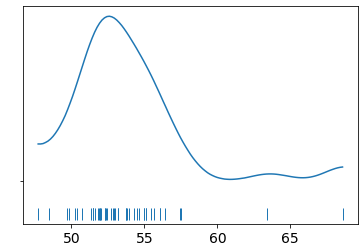

In [13]:
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

[45.634, 70.666, 10.312458871064944]


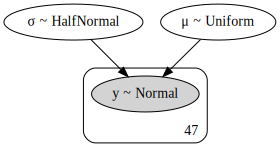

In [20]:
# We will infer a posterior for the mean and variance.
# We use a uniform prior for the mean, with support slightly larger than the data
r = np.max(data)-np.min(data)
min_mu = np.min(data)-0.1*r
max_mu = np.max(data)+0.1*r
# We use a truncated normal for the variance, with effective support uniform 0 to 3*std
prior_std = 3*np.std(data)
print([min_mu, max_mu, prior_std])

with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=min_mu, upper=max_mu)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)

pm.model_to_graphviz(model_g) # show the DAG


In [0]:
with model_g:
    trace_g = pm.sample(1000, random_seed=123)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ab7ee2e48>,
      dtype=object)

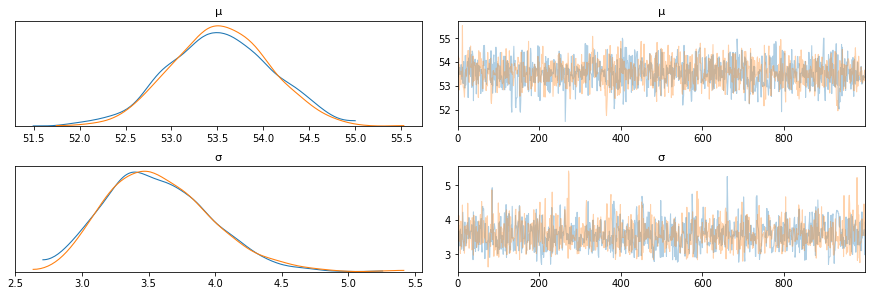

In [22]:
az.plot_trace(trace_g)

In [21]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.535,0.545,52.545,54.550,0.014,0.010,1627.0,1627.0,1638.0,1115.0,1.0
σ,3.576,0.389,2.896,4.294,0.010,0.007,1477.0,1440.0,1502.0,1173.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ab5d9b470>,
      dtype=object)

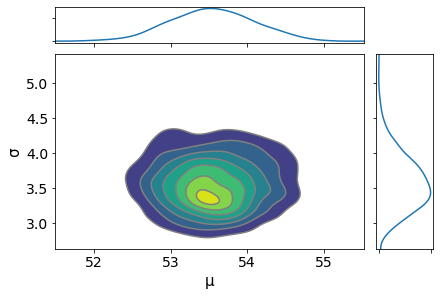

In [23]:
az.plot_joint(trace_g, kind='kde', fill_last=False)

## Posterior predictive checks

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 1032.06it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


dict_keys(['y'])
<class 'numpy.ndarray'>
(100, 47)


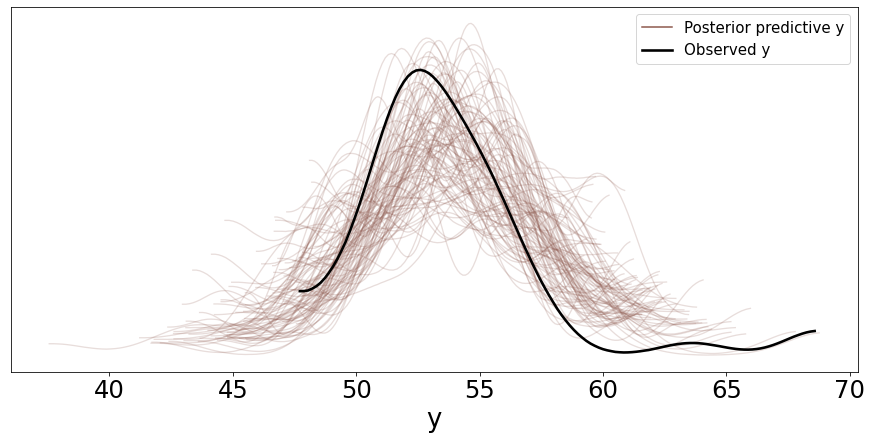

In [34]:
# We check how well the gaussian assumption fits our data
# by sampling from the fitted model, and plotting the samples
# and the original data.
# The mean and variance is higher than for the observed data, indicating poor fit.
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)
print(y_pred_g.keys())
v=y_pred_g['y']
print(type(v))
print(v.shape) # 100x47

data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)




In [33]:
print(y_pred_g.keys())
v=y_pred_g['y']
print(type(v))
print(v.shape)

dict_keys(['y'])
<class 'numpy.ndarray'>
(100, 47)


## Robust likelihood (1d Student distribution)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, μ]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 857.23it/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.077,0.388,52.340,53.774,0.010,0.007,1365.0,1365.0,1366.0,867.0,1.0
σ,2.188,0.403,1.507,2.977,0.012,0.009,1043.0,1043.0,1035.0,1275.0,1.0
ν,4.500,3.510,1.270,9.556,0.115,0.081,933.0,933.0,1095.0,1125.0,1.0


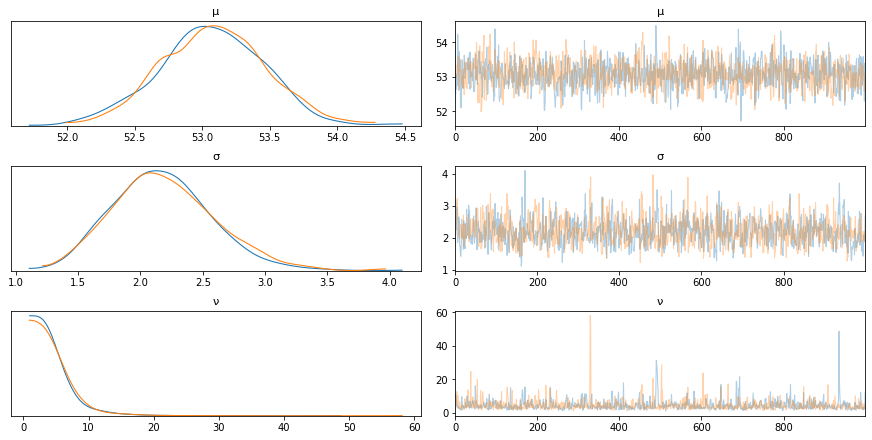

In [35]:
# We replace the above Gaussian likelihood with a Student t distribution.
# The degree of freedom parameter \nu > 0 (also called the "normality parameter")
# determines how close to Normal the distribution is.
# nu=1 corredsponds to a Cauchy, nu >> 10 corresponds to a Gaussian.
# We put an Exponential prior on nu, with a mean of 30.

with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30) # PyMC3 uses inverse of the mean
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)

pm.model_to_graphviz(model_t) # show the DAG

with model_t:
    trace_t = pm.sample(1000)

az.plot_trace(trace_t)

az.summary(trace_t)
# We see that E[nu]=4.5, which is fairly far from Gaussian
# We see E[sigma]=2.1, wich is less than the 3.5 estimate from Gaussian likelihood


/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 1055.67it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


(40.0, 70.0)

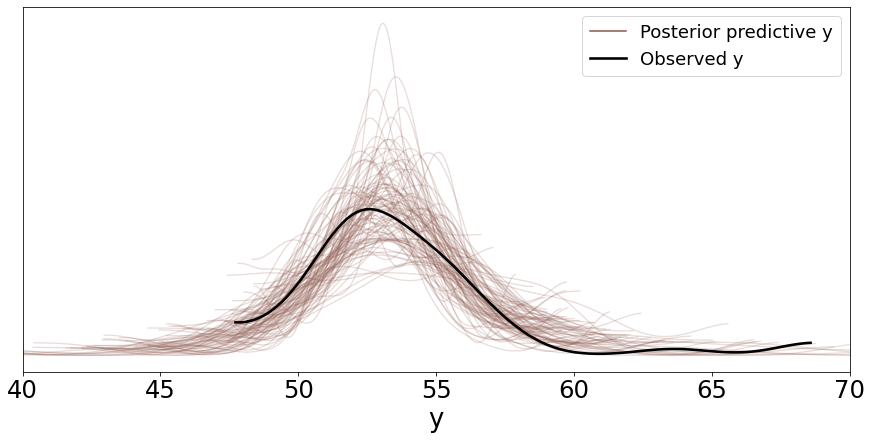

In [36]:
# posterior predictive check

y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.xlim(40, 70)

In [38]:
# Remove outliers from data and compare empirical mean and variance of cleaned data
# to posterior mean and posterior scale of a Student likelihood

# https://gist.github.com/vishalkuo/f4aec300cf6252ed28d3
def removeOutliers(x, outlierConstant=1.5):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    return result.tolist()

data_clean = removeOutliers(data)
print([np.mean(data), np.mean(data_clean)])
print([np.std(data), np.std(data_clean)])


[53.548297872340434, 52.994666666666674]
[3.4374862903549817, 2.200877198856048]


# Comparing means of different datasets

We often want to know if one dataset, $D_i$,  has a "statistically signficant" difference in one of its parameters, such as its mean $\mu_i$, compared to some other dataset, $D_j$. We can answer this in a Bayesian way by computing $p(\delta_{ij}|D_i,D_j)$, where

$\delta_{ij}=\mu_i-\mu_j$.

To do this, we draw samples from $p(\mu_i|D_i)$ and $p(\mu_j|D_j)$.

Since the magnitude of $\delta_{ij}$ can be hard to interpret, it is common to divide it by the pooled standard deviation, to get a metric known as Cohen's d (see [this website](https://rpsychologist.com/d3/cohend/) for details):

$d_{ij} = \frac{\mu_j - \mu_i}{\sqrt{\frac{\sigma_i^2 + \sigma_j^2}{2}}}$

We can compute $p(d_{ij}|D_i,D_j)$ using posterior samples of $\mu_i,\mu_j,\sigma_i,\sigma_j$.








In [48]:
#We illustrate this below using the same dataset as used in chap 2 of
#["Bayesian Analysis with Python (2nd end)"](https://github.com/aloctavodia/BAP) that records how much tips waiters made.

url = 'https://raw.githubusercontent.com/aloctavodia/BAP/master/code/data/tips.csv'
df = pd.read_csv(url)
df.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


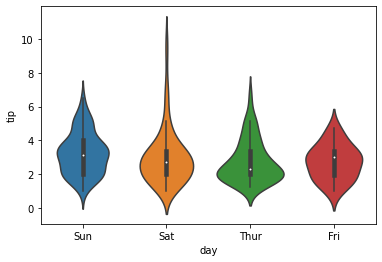

In [46]:
# We look at the effect of day on tip amount.
# We ignore other covariates, such as gender.

sns.violinplot(x='day', y='tip', data=df)


In [51]:
# We will compute 4 groups, corresponding to Thur-Sun.
x=df['day'].values
print(type(x))
print(x)
print(np.unique(x))

<class 'numpy.ndarray'>
['Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun'
 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat'
 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat'
 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun'
 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sat' 'Sat' 'Sat' 'Sat'
 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat'
 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur'
 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Fri' 'Fri' 'Fri' 'Fri'
 'Fri' 'Fri' 'Fri' 'Fri' 'Fri' 'Fri' 'Fri' 'Fri' 'Sat' 'Sat' 'Sat' 'Sat'
 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Thur'
 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur'
 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur'
 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur'
 'Thur' 'Thur' 'Sun' 'Sun' 'Sun

In [67]:
tip_amount = df['tip'].values
days = ['Thur', 'Fri', 'Sat', 'Sun']
idx = pd.Categorical(tips['day'], categories=days).codes
ngroups = len(np.unique(idx))
print(idx)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[μ, σ_log__, y]


Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]
Sampling chain 1, 0 divergences: 100%|██████████| 5500/5500 [00:05<00:00, 919.67it/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],2.770,0.162,2.469,3.078,0.001,0.001,12816.0,12699.0,12846.0,7972.0,1.0
μ[1],2.732,0.250,2.268,3.208,0.003,0.002,8791.0,8791.0,8927.0,6985.0,1.0
μ[2],2.992,0.178,2.653,3.320,0.002,0.001,12015.0,12015.0,12037.0,7042.0,1.0
μ[3],3.255,0.144,2.985,3.523,0.001,0.001,12028.0,11919.0,12093.0,7467.0,1.0
σ[0],1.264,0.116,1.064,1.494,0.001,0.001,11665.0,11170.0,12329.0,7697.0,1.0
σ[1],1.094,0.198,0.768,1.473,0.002,0.002,8779.0,7947.0,9898.0,6861.0,1.0
σ[2],1.654,0.126,1.433,1.901,0.001,0.001,11351.0,11129.0,11410.0,7870.0,1.0
σ[3],1.255,0.105,1.071,1.460,0.001,0.001,10241.0,9897.0,10768.0,7375.0,1.0


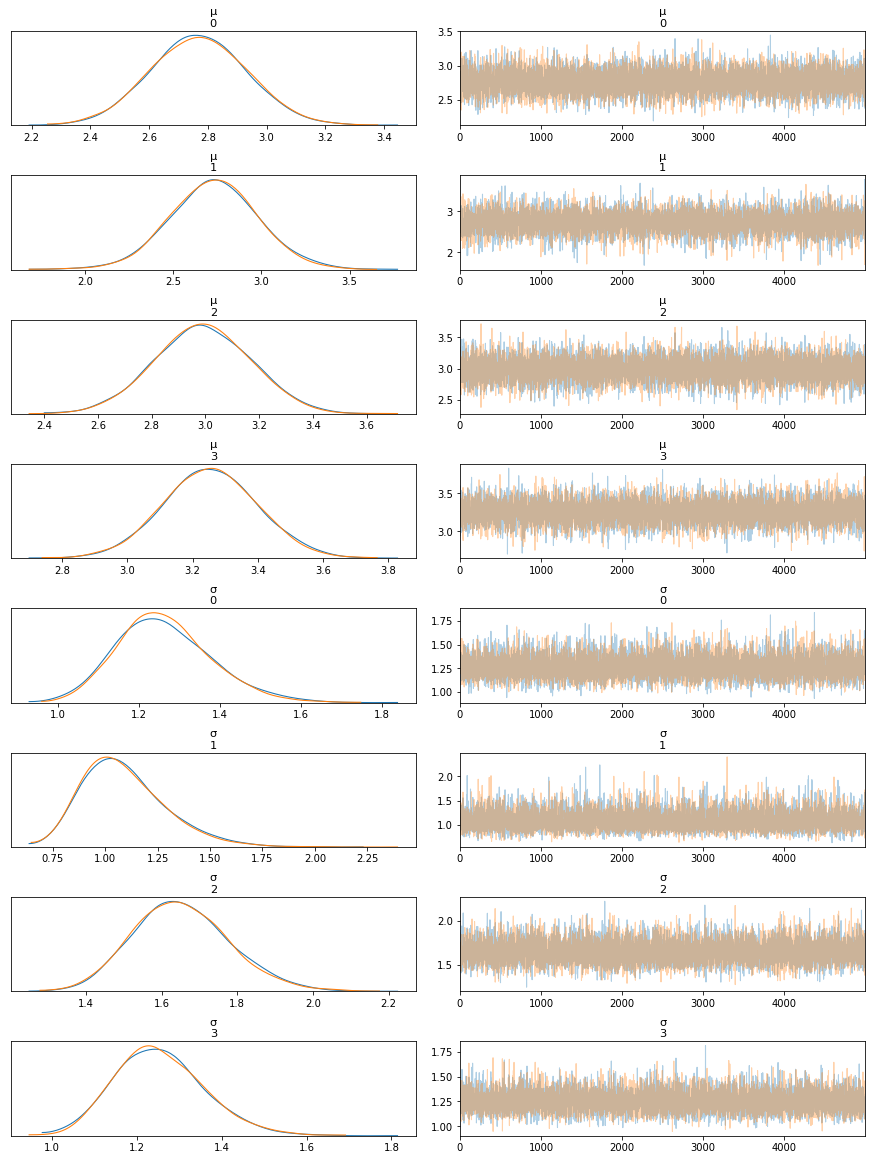

In [69]:
with pm.Model() as model_cg:
    μ = pm.Normal('μ', mu=0, sd=10, shape=ngroups)
    σ = pm.HalfNormal('σ', sd=10, shape=ngroups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip_amount)

print(model_cg.basic_RVs)

with model_cg:
    trace_cg = pm.sample(5000)

az.plot_trace(trace_cg)
az.summary(trace_cg)

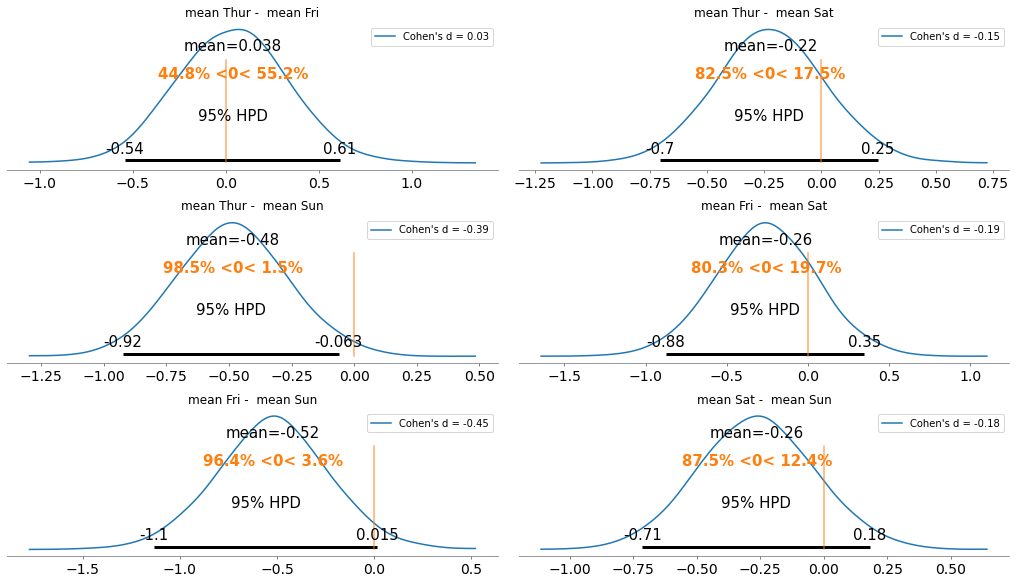

In [70]:
# Looking at the posterior mean for the mu_i,
# we see Thur ~ Fri < Sat < Sun.
# But to see if these differences are significant, we should take
# into account the variability. We illustrate this below.
# We see that Thursday and Friday both earn significantly less than Sunday.
# (The threshold of 0 is outside the 95% HPD).
# Other differences are less significant.

fig, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(ngroups) for j in range(i+1, ngroups)]
pos = [(k, l) for k in range(ngroups-1) for l in (0, 1)] # position of plot

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l],  credible_interval=0.95)
    name_i = days[i]
    name_j = days[j]
    str = 'mean {} -  mean {}'.format(name_i, name_j)
    ax[k, l].set_title(str)
    ax[k, l].plot(0, label=f"Cohen's d = {d_cohen:.2f}")
    ax[k, l].legend()


# Hierarchical Bayes

## Beta-Binomial model

We use the "cancer rates" example from the MLAPP2.0 book.
For PyMC3 code for  "rats" example from BDA3, see [here](https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html).



In [88]:
#https://github.com/probml/pmtk3/blob/master/demos/cancerRatesEb.m

data_y = np.array([0, 0, 2, 0, 1, 1, 0, 2, 1, 3, 0, 1, 1, 1, 54, 0, 0, 1, 3, 0]);
data_n = np.array([1083, 855, 3461, 657, 1208, 1025, 527, 1668, 583, 582, 917, 857,
    680, 917, 53637, 874, 395, 581, 588, 383]);
N = len(data_n)

# We put a prior on the mean and precision () of the Beta distribution,
# instead of on the alpha and beta parameters 
with pm.Model() as model_h:
    mu = pm.Beta('mu', 1., 1.)
    kappa = pm.HalfNormal('kappa', 1)
    theta = pm.Beta('theta', alpha=mu*kappa, beta=(1.0-mu)*kappa, shape=N)
    y = pm.Binomial('y', p=theta, observed=data_y, n=data_n)

np.random.seed(0)
with model_h:
  trace_h = pm.sample(1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta, kappa, mu]
Sampling chain 3, 1 divergences: 100%|██████████| 1500/1500 [00:09<00:00, 153.14it/s]
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [89]:
pm.summary(trace_h).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.07,0.03,0.02,0.14,0.00,0.00,1429.0,1429.0,1414.0,1838.0,1.00
kappa,1.58,0.64,0.44,2.76,0.02,0.01,1554.0,1554.0,1470.0,1745.0,1.00
theta[0],0.00,0.00,0.00,0.00,0.00,0.00,4126.0,3960.0,831.0,635.0,1.00
theta[1],0.00,0.00,0.00,0.00,0.00,0.00,4023.0,4001.0,896.0,591.0,1.00
theta[2],0.00,0.00,0.00,0.00,0.00,0.00,3000.0,3000.0,2335.0,1553.0,1.00
theta[3],0.00,0.00,0.00,0.00,0.00,0.00,4156.0,4108.0,1011.0,729.0,1.00
theta[4],0.00,0.00,0.00,0.00,0.00,0.00,3930.0,3930.0,2696.0,1778.0,1.00
theta[5],0.00,0.00,0.00,0.00,0.00,0.00,3300.0,3300.0,1955.0,1244.0,1.00
theta[6],0.00,0.00,0.00,0.00,0.00,0.00,3941.0,3941.0,776.0,523.0,1.01
theta[7],0.00,0.00,0.00,0.00,0.00,0.00,3791.0,3791.0,2541.0,1517.0,1.00


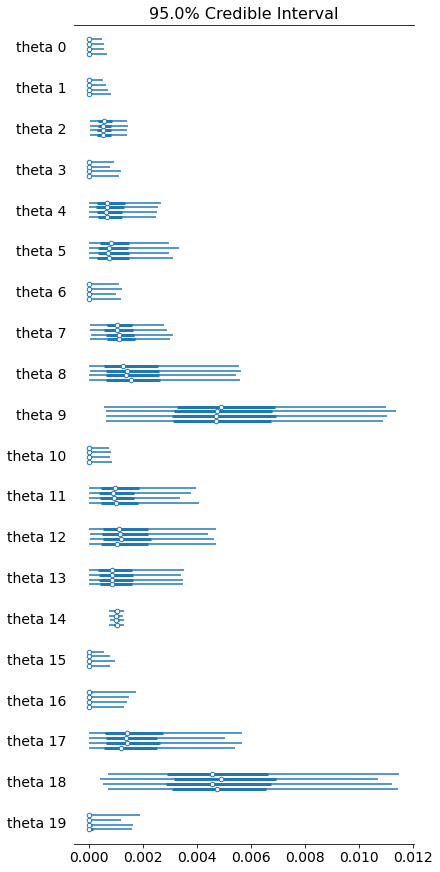

In [90]:
az.plot_forest(trace_h, var_names=["theta"], credible_interval=0.95);


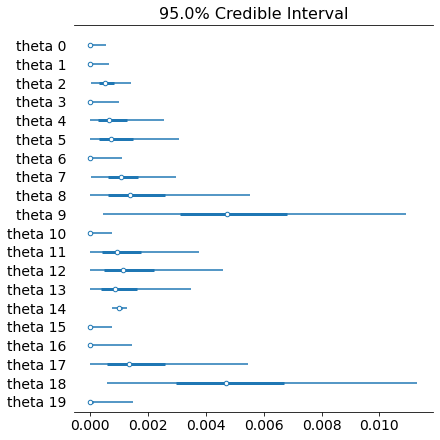

In [91]:
az.plot_forest(trace_h, var_names=["theta"], combined=True, credible_interval=0.95);

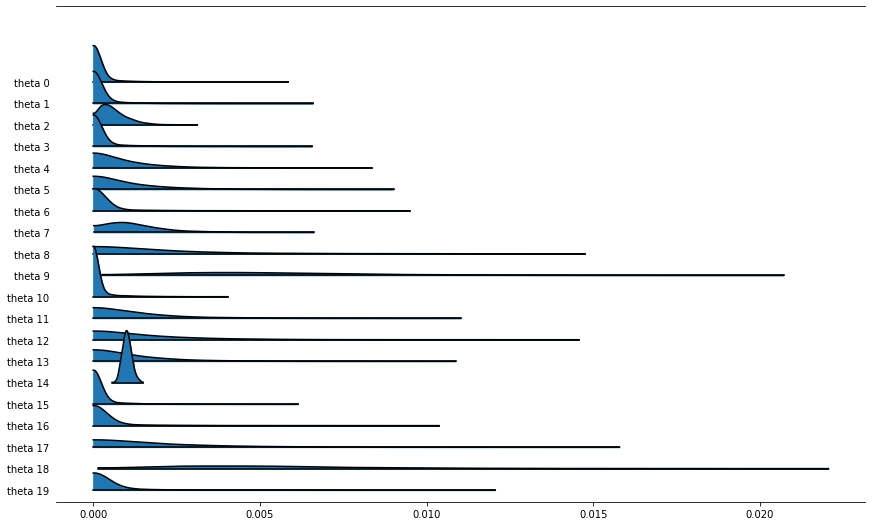

In [92]:
az.plot_forest(trace_h, var_names=["theta"], combined=True, kind='ridgeplot');